# AI6126 ACV Project 1


In [1]:
nb_ver = 0.8
title = f'ai6126-project1-colab-v{nb_ver}'
print(title)
comments = "sched"
print(comments)

ai6126-project1-colab-v0.8
sched


## Versioning & References

### Changelogs
+ V0.1 - Setup codes to download and unzip celeba to gDrive
+ V0.2 - Added training loop 
+ V0.3 - Added seeding + save/ load checkpoint
+ V0.4 - Added time taken + save output
+ V0.5 - Added RandomErasing to transforms
+ V0.6 - Added get_criterion (BinaryFocalLoss) - NOT WORKING YET
+ V0.7 - Added FaceAttrMobileNetV2 & FaceAttrResNeXt
+ V0.8 - Added Albumentations

### References
+ [PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
+ [TWD fast.ai](https://towardsdatascience.com/real-time-multi-facial-attribute-detection-using-transfer-learning-and-haar-cascades-with-fastai-47ff59e36df0)

### Dependencies

In [2]:
# conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
# conda install matplotlib
# conda install pandas
# conda install tqdm
# conda install -c conda-forge jupyterlab
# conda install -c conda-forge tensorboard
# conda install -c conda-forge protobuf # for tensorboard
# conda install nb_conda_kernels # auto add kernels

# conda install -c conda-forge imgaug
# conda install albumentations -c conda-forge

## Setup/ Configuration

### Colab

In [3]:
# you can choose to mount your Google Drive (optional)
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    file_name = f'ai6126-project1-colab-v{nb_ver}.ipynb'
    print(file_name)
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd

In [4]:
# check nvcc version
!nvcc -V
# check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:12:52_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.1, V10.1.243


'gcc' is not recognized as an internal or external command,
operable program or batch file.


### Download Dataset

In [5]:
import os, glob
local_download_path = '../data/celeba/img_align_celeba'
download_dataset = True
if os.path.exists(local_download_path):
    images = glob.glob(local_download_path + '/*.jpg')
    if len(images) == 202599:
        download_dataset = False
print(f"download celeba dataset: {download_dataset}")

if download_dataset:
    # create dataset root and enter it
    !mkdir -p data/celeba
    %cd data/celeba

    # we have prepared a backup of `img_align_celeba.zip` of Celeb-A dataset in the Dropbox
    # download it directly, or manually download the original file from Google Drive above
    !wget https://www.dropbox.com/s/8kzo40fqx7nodat/img_align_celeba.zip

    # unzip the downloaded file
    !unzip -qq img_align_celeba.zip
    !rm -f img_align_celeba.zip

    # change the directory back to the root
    %cd ../..
    !ls

download celeba dataset: False


## Implementation

### Imports

In [6]:
import sys, os
import time
import random
import numpy as np
import copy
from datetime import datetime
from distutils.dir_util import copy_tree #for recursive filecopying

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from tqdm import tqdm
import matplotlib.pyplot as plt

import config
from celeba_dataset import CelebaDataset
import models
import losses
from utils import Logger, AverageMeter, Bar, savefig, adjust_learning_rate, accuracy, reset_gpu_cache, print_attribute_acc, create_dir_ifne

In [7]:
# set the backend of matplotlib to the 'inline' backend
%matplotlib inline

# check PyTorch version and cuda status
print(torch.__version__, torch.cuda.is_available())

# define device
device = torch.device("cuda:"+config.gpu_id if torch.cuda.is_available() else "cpu")
print(device)

if 'ipykernel' in sys.modules:
    config.disable_tqdm = False
print(f"disable_tqdm: {config.disable_tqdm}")

1.6.0 True
cuda:0
disable_tqdm: False


### Seeding

In [8]:
# set random seed for reproducibility
def seed_everything(seed=None):
    if seed is None:
        seed = random.randint(1, 10000) # create random seed
        print(f'random seed used: {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    if 'torch' in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
    
seed_everything(seed=config.manual_seed)

### Data Transform

In [9]:
# attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
#                    'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
#                    'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
#                    'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
#                    'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
#                    'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
#                    'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
# print(attribute_names)

In [10]:
# Data augmentation and normalization for training
# Just normalization for validation and testing

def load_dataloaders(print_info=True, albu_transforms = True):
    if config.evaluate:
        phases = ['test']
    else:
        phases = ['train', 'val']

    attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
                       'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
                       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
                       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
                       'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
                       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
                       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
    
    attributes_list = {
        'train': config.TRAIN_ATTRIBUTE_LIST,
        'val': config.VAL_ATTRIBUTE_LIST,
        'test': config.TEST_ATTRIBUTE_LIST
    }

    batch_sizes = {
        'train': config.train_batch,
        'val': config.test_batch,
        'test': config.test_batch
    }

    if not albu_transforms:
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize(128), #new
                transforms.CenterCrop(128), #new
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10), #new
                transforms.ToTensor(),
                normalize,
                transforms.RandomErasing()
            ]),
            'val': transforms.Compose([
                transforms.Resize(128), #new
                transforms.ToTensor(),
                normalize
            ]),
            'test': transforms.Compose([
                transforms.Resize(128), #new
                transforms.ToTensor(),
                normalize
            ])
        }
    else:
        normalize_A = A.Normalize(mean=(0.485, 0.456, 0.406), 
                                  std=(0.229, 0.224, 0.225))
        data_transforms = {
            'train': A.Compose(
            [
                A.SmallestMaxSize(max_size=160),
                A.HorizontalFlip(p=0.5),
                A.MotionBlur(p=0.1),
                A.GaussNoise(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, 
                                   rotate_limit=15, p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                #A.CoarseDropout(),
                normalize_A,
                ToTensorV2(),
                
            ]),
            'val': A.Compose(
                [
                    A.SmallestMaxSize(max_size=160),
                    #A.CenterCrop(height=128, width=128),
                    normalize_A,
                    ToTensorV2(),
                ]
            ),
            'test': A.Compose([
                A.SmallestMaxSize(max_size=160),
                #A.CenterCrop(height=128, width=128),
                normalize_A,
                ToTensorV2(),
            ])
        }

    image_datasets = {x: CelebaDataset(config.IMG_DIR, attributes_list[x], 
                                       data_transforms[x]) 
                      for x in phases}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                  batch_size=batch_sizes[x],
                                                  pin_memory=True, shuffle=(x == 'train'), 
                                                  num_workers=config.dl_workers) 
                   for x in phases}
    if print_info:
        dataset_sizes = {x: len(image_datasets[x]) for x in phases}
        print(f"Dataset sizes: {dataset_sizes}")
        
    if config.evaluate:
        class_names = image_datasets['test'].targets
    else:
        class_names = image_datasets['train'].targets
    print(f"Class Labels: {len(class_names[0])}")
    assert len(attribute_names) == len(class_names[0])
    return dataloaders, attribute_names

### Model Architecture Initialization

In [11]:
model_names = sorted(name for name in models.__dict__
                     if callable(models.__dict__[name])) # and name.islower() and not name.startswith("__"))
print(f"Available Models: {model_names}")

Available Models: ['FaceAttrMobileNetV2', 'FaceAttrResNeXt', 'FaceAttrResNet']


In [12]:
def create_model(device):
    print("=> creating model '{}'".format(config.arch))
    if config.arch.startswith('FaceAttrResNet'):
        model = models.__dict__[config.arch](resnet_layers = config.pt_layers)
    elif config.arch.startswith('FaceAttrResNeXt'):
        model = models.__dict__[config.arch](resnet_layers = config.pt_layers)
    elif config.arch.startswith('FaceAttrMobileNetV2'):
        model = models.__dict__[config.arch]()
    #print(model)
    model = model.to(device)
    return model
#print(model)

### Criterion & Optimizer

In [13]:
def get_criterion():
    criterion = nn.CrossEntropyLoss().to(device)
    if config.criterion == 'BinaryFocalLoss':
        criterion = losses.BinaryFocalLoss().to(device)
    elif config.criterion == 'FocalLoss':
        criterion = losses.FocalLossV2().to(device)
    return criterion

### Resume Checkpoint if any

In [14]:
def resume_checkpoint(model, optimizer, ckp_logger_fname, ckp_resume=None):
    if not os.path.isdir(config.CHECKPOINT_DIR):
        try: 
            os.makedirs(config.CHECKPOINT_DIR)
        except OSError:
            raise
            
    start_epoch = 0
    best_prec1 = 0
    if ckp_resume and os.path.isfile(ckp_resume): 
        print(f"=> resuming model: {ckp_resume}")
        optimizer, start_epoch, best_prec1 = model.load_ckp(optimizer, ckp_resume)
        config.checkpoint = os.path.dirname(ckp_resume)
        logger = Logger(ckp_logger_fname, title=model.name, resume=True)
    else:
        logger = Logger(ckp_logger_fname, title=model.name)
        logger.set_names(['Learning Rate', 'Train Loss', 'Valid Loss', 'Train Acc.', 'Valid Acc.'])
        
        
    return best_prec1, start_epoch, logger

## Train & Validate Function

In [15]:
def train(train_loader, model, criterion, optimizer):
    bar = Bar('Processing', max=len(train_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to train mode
    model.train()

    end = time.time()
    for i, (X, y) in enumerate(tqdm(train_loader, disable=config.disable_tqdm)):
        # measure data loading time
        data_time.update(time.time() - end)

        # Overlapping transfer if pinned memory
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
    
        # compute output
        output = model(X)
        # measure accuracy and record loss
        loss = []
        prec1 = []
        for j in range(len(output)): 
            # output[j]: [N,C] y[:,j]:[N]
            # CE Criterion: [] scalar
#             print("output s: ", output[j].shape)
#             print("output y: ", y[:, j].shape)
            crit = criterion(output[j], y[:, j])
#             print(crit.detach())
            loss.append(crit)
            prec1.append(accuracy(output[j], y[:, j], topk=(1,)))
            losses[j].update(loss[j].detach().item(), X.size(0))
            top1[j].update(prec1[j][0].item(), X.size(0))
            
        losses_avg = [losses[k].avg for k in range(len(losses))]
        top1_avg = [top1[k].avg for k in range(len(top1))]
        loss_avg = sum(losses_avg) / len(losses_avg)
        prec1_avg = sum(top1_avg) / len(top1_avg)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss_sum = sum(loss)
        loss_sum.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        print_line = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                        batch=i + 1,
                        size=len(train_loader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=loss_avg,
                        top1=prec1_avg,
                        )
        if not config.disable_tqdm and (i+1)% 100 == 0:
            print(print_line)
        bar.suffix  = print_line
        bar.next()
    bar.finish()
    return (loss_avg, prec1_avg)

In [16]:
def validate(val_loader, model, criterion):
    bar = Bar('Processing', max=len(val_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (X, y) in enumerate(tqdm(val_loader, disable=config.disable_tqdm)):
            # measure data loading time
            data_time.update(time.time() - end)

            # Overlapping transfer if pinned memory
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # compute output
            output = model(X)
            # measure accuracy and record loss
            loss = []
            prec1 = []
            for j in range(len(output)):
                loss.append(criterion(output[j], y[:, j]))
                prec1.append(accuracy(output[j], y[:, j], topk=(1,)))
                
                losses[j].update(loss[j].detach().item(), X.size(0))
                top1[j].update(prec1[j][0].item(), X.size(0))
            losses_avg = [losses[k].avg for k in range(len(losses))]
            top1_avg = [top1[k].avg for k in range(len(top1))]
            loss_avg = sum(losses_avg) / len(losses_avg)
            prec1_avg = sum(top1_avg) / len(top1_avg)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # plot progress
            print_line = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                            batch=i + 1,
                            size=len(val_loader),
                            data=data_time.avg,
                            bt=batch_time.avg,
                            total=bar.elapsed_td,
                            eta=bar.eta_td,
                            loss=loss_avg,
                            top1=prec1_avg,
                            )
            if not config.disable_tqdm and (i+1)% 100 == 0:
                print(print_line)
            bar.suffix  = print_line
            bar.next()  
    bar.finish()
    return (loss_avg, prec1_avg, top1)

## Main Function

In [17]:
def trainer(dataloaders, model, criterion, optimizer, logger, start_epoch, best_prec1, run_name):
    # visualization
    writer = SummaryWriter(os.path.join(config.tensorboard_dir, run_name))

    for epoch in range(start_epoch, config.epochs):
        lr = adjust_learning_rate(optimizer, config.lr_decay, epoch, gamma=config.gamma, step=config.step,
                                 total_epochs=config.epochs, turning_point=config.turning_point,
                                 schedule=config.schedule)

        print('\nEpoch: [%d | %d] LR: %.16f' % (epoch + 1, config.epochs, lr))

        # train for one epoch
        train_loss, train_acc = train(dataloaders['train'], model, criterion, optimizer)

        # evaluate on validation set
        val_loss, prec1, _ = validate(dataloaders['val'], model, criterion)

        # append logger file
        logger.append([lr, train_loss, val_loss, train_acc, prec1])

        # tensorboardX
        writer.add_scalar('learning rate', lr, epoch + 1)
        writer.add_scalars('loss', {'train loss': train_loss, 'validation loss': val_loss}, epoch + 1)
        writer.add_scalars('accuracy', {'train accuracy': train_acc, 'validation accuracy': prec1}, epoch + 1)
        #for name, param in model.named_parameters():
        #    writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch + 1)

        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        model.save_ckp({
            'epoch': epoch + 1,
            'arch': model.name,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict()
        }, is_best, config.checkpoint_fname,config.bestmodel_fname)

    logger.close()
    logger.plot()
    savefig(config.train_plotfig)
    writer.close()

    print('Best accuracy:')
    print(best_prec1)

In [18]:
def get_run_name_time(model, criterion, optimizer, comments):
    try:
        if criterion.name:
            p_criterion = criterion.name
    except:
        p_criterion = 'CE'

    p_optimizer = f'{str(optimizer).split("(")[0].strip()}'
    p_scheduler = f'{config.lr_decay}_lr{config.lr}_wd{config.weight_decay}'
    if config.lr_decay == 'step':
        p_scheduler += f'_g{config.gamma}_sp{config.step}'
    elif config.lr_decay == 'linear2exp':
        p_scheduler += f'_g{config.gamma}_tp{config.turning_point}'
    elif config.lr_decay == 'schedule':
        p_scheduler += f'_g{config.gamma}_sch{config.schedule}'

    run_name = f'{model.name}_{config.manual_seed}_s{start_epoch}e{config.epochs}_' \
                + f'tb{config.train_batch}_vb{config.test_batch}_' \
                + f'{p_criterion}_{p_optimizer}_' \
                + f'{comments}_' \
                + f'{p_scheduler}'
    
    run_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    print(run_name, run_time)
    return run_name, run_time

=> creating model 'FaceAttrResNet'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

Dataset sizes: {'train': 162770, 'val': 19867}
Class Labels: 40
FaceAttrResNet18_42_s0e60_tb256_vb128_CE_SGD_sched_schedule_lr0.1_wd0.0001_g0.1_sch[30, 35, 40, 45, 50, 55, 56, 57, 58, 59, 60] 20201005_083231

Epoch: [1 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [02:27<10:52,  1.22s/it]

(100/636) Data: 0.976s | Batch: 1.479s | Total: 0:02:27 | ETA: 0:10:27 | Loss: 0.6077 | top1:  79.5086


 31%|█████████████████████████▏                                                      | 200/636 [04:32<06:23,  1.14it/s]

(200/636) Data: 0.898s | Batch: 1.362s | Total: 0:04:32 | ETA: 0:08:16 | Loss: 0.5677 | top1:  79.9536


 47%|█████████████████████████████████████▋                                          | 300/636 [06:38<10:03,  1.79s/it]

(300/636) Data: 0.863s | Batch: 1.327s | Total: 0:06:38 | ETA: 0:06:12 | Loss: 0.5530 | top1:  80.0641


 63%|██████████████████████████████████████████████████▎                             | 400/636 [08:37<03:33,  1.11it/s]

(400/636) Data: 0.826s | Batch: 1.293s | Total: 0:08:37 | ETA: 0:04:00 | Loss: 0.5407 | top1:  80.1470


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [10:36<03:27,  1.53s/it]

(500/636) Data: 0.803s | Batch: 1.273s | Total: 0:10:36 | ETA: 0:02:23 | Loss: 0.5295 | top1:  80.2022


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [12:30<00:27,  1.32it/s]

(600/636) Data: 0.782s | Batch: 1.251s | Total: 0:12:30 | ETA: 0:00:41 | Loss: 0.5205 | top1:  80.2453


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.70it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [2 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:48,  1.86it/s]

(100/636) Data: 0.123s | Batch: 0.661s | Total: 0:01:06 | ETA: 0:04:47 | Loss: 0.4619 | top1:  80.4716


 31%|█████████████████████████▏                                                      | 200/636 [01:59<03:55,  1.86it/s]

(200/636) Data: 0.063s | Batch: 0.600s | Total: 0:01:59 | ETA: 0:03:56 | Loss: 0.4585 | top1:  80.4787


 47%|█████████████████████████████████████▋                                          | 300/636 [02:53<03:00,  1.86it/s]

(300/636) Data: 0.043s | Batch: 0.579s | Total: 0:02:53 | ETA: 0:03:02 | Loss: 0.4544 | top1:  80.6096


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:47<02:07,  1.85it/s]

(400/636) Data: 0.033s | Batch: 0.569s | Total: 0:03:47 | ETA: 0:02:07 | Loss: 0.4475 | top1:  80.9662


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:41<01:13,  1.85it/s]

(500/636) Data: 0.026s | Batch: 0.563s | Total: 0:04:41 | ETA: 0:01:15 | Loss: 0.4408 | top1:  81.2501


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:35<00:19,  1.85it/s]

(600/636) Data: 0.022s | Batch: 0.559s | Total: 0:05:35 | ETA: 0:00:20 | Loss: 0.4342 | top1:  81.5037


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.21it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [3 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:49,  1.85it/s]

(100/636) Data: 0.122s | Batch: 0.660s | Total: 0:01:06 | ETA: 0:04:51 | Loss: 0.3798 | top1:  83.6217


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:54,  1.86it/s]

(200/636) Data: 0.062s | Batch: 0.600s | Total: 0:02:00 | ETA: 0:03:56 | Loss: 0.3725 | top1:  83.8696


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.85it/s]

(300/636) Data: 0.042s | Batch: 0.580s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.3655 | top1:  84.1532


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.84it/s]

(400/636) Data: 0.032s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:08 | Loss: 0.3602 | top1:  84.4215


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.84it/s]

(500/636) Data: 0.026s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:14 | Loss: 0.3574 | top1:  84.5640


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.85it/s]

(600/636) Data: 0.022s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:21 | Loss: 0.3525 | top1:  84.7852


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.28it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [4 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:49,  1.85it/s]

(100/636) Data: 0.124s | Batch: 0.663s | Total: 0:01:06 | ETA: 0:04:50 | Loss: 0.3153 | top1:  86.3733


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:54,  1.86it/s]

(200/636) Data: 0.063s | Batch: 0.602s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.3110 | top1:  86.5474


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.84it/s]

(300/636) Data: 0.042s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:04 | Loss: 0.3076 | top1:  86.6710


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.84it/s]

(400/636) Data: 0.032s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:10 | Loss: 0.3046 | top1:  86.7836


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.84it/s]

(500/636) Data: 0.026s | Batch: 0.566s | Total: 0:04:42 | ETA: 0:01:14 | Loss: 0.3029 | top1:  86.8414


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.86it/s]

(600/636) Data: 0.022s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:20 | Loss: 0.3002 | top1:  86.9475


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.25it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [5 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:51,  1.84it/s]

(100/636) Data: 0.120s | Batch: 0.659s | Total: 0:01:05 | ETA: 0:04:51 | Loss: 0.2776 | top1:  87.8075


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:57,  1.84it/s]

(200/636) Data: 0.061s | Batch: 0.600s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.2757 | top1:  87.8948


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:00,  1.86it/s]

(300/636) Data: 0.041s | Batch: 0.580s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.2731 | top1:  88.0066


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.84it/s]

(400/636) Data: 0.032s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.2712 | top1:  88.1048


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.84it/s]

(500/636) Data: 0.026s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.2693 | top1:  88.1865


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.84it/s]

(600/636) Data: 0.022s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:20 | Loss: 0.2678 | top1:  88.2524


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.24it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [6 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:50,  1.85it/s]

(100/636) Data: 0.122s | Batch: 0.663s | Total: 0:01:06 | ETA: 0:04:52 | Loss: 0.2674 | top1:  88.3067


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:57,  1.84it/s]

(200/636) Data: 0.062s | Batch: 0.602s | Total: 0:02:00 | ETA: 0:03:58 | Loss: 0.2624 | top1:  88.4762


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:00,  1.86it/s]

(300/636) Data: 0.042s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:02 | Loss: 0.2592 | top1:  88.6084


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.84it/s]

(400/636) Data: 0.032s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:10 | Loss: 0.2570 | top1:  88.7042


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:43<01:14,  1.83it/s]

(500/636) Data: 0.026s | Batch: 0.567s | Total: 0:04:43 | ETA: 0:01:15 | Loss: 0.2552 | top1:  88.7839


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.84it/s]

(600/636) Data: 0.022s | Batch: 0.563s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.2536 | top1:  88.8455


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.25it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [7 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:50,  1.85it/s]

(100/636) Data: 0.119s | Batch: 0.663s | Total: 0:01:06 | ETA: 0:04:51 | Loss: 0.2426 | top1:  89.2728


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:54,  1.86it/s]

(200/636) Data: 0.061s | Batch: 0.602s | Total: 0:02:00 | ETA: 0:03:56 | Loss: 0.2409 | top1:  89.3670


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<02:59,  1.87it/s]

(300/636) Data: 0.041s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:02 | Loss: 0.2424 | top1:  89.3083


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.032s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.2424 | top1:  89.3084


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:14,  1.84it/s]

(500/636) Data: 0.026s | Batch: 0.566s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.2417 | top1:  89.3362


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.85it/s]

(600/636) Data: 0.022s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:20 | Loss: 0.2408 | top1:  89.3753


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.23it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [8 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:48,  1.86it/s]

(100/636) Data: 0.118s | Batch: 0.661s | Total: 0:01:06 | ETA: 0:04:52 | Loss: 0.2333 | top1:  89.6810


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:53,  1.86it/s]

(200/636) Data: 0.060s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:58 | Loss: 0.2327 | top1:  89.7148


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:01,  1.85it/s]

(300/636) Data: 0.041s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.2325 | top1:  89.7296


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.031s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.2319 | top1:  89.7552


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.85it/s]

(500/636) Data: 0.025s | Batch: 0.566s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.2313 | top1:  89.7808


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.84it/s]

(600/636) Data: 0.021s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.2309 | top1:  89.7996


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.25it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [9 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:48,  1.85it/s]

(100/636) Data: 0.118s | Batch: 0.661s | Total: 0:01:06 | ETA: 0:04:51 | Loss: 0.2248 | top1:  90.0648


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:55,  1.85it/s]

(200/636) Data: 0.060s | Batch: 0.602s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.2253 | top1:  90.0553


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:00,  1.86it/s]

(300/636) Data: 0.041s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.2249 | top1:  90.0668


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.84it/s]

(400/636) Data: 0.031s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.2246 | top1:  90.0713


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:43<01:17,  1.76it/s]

(500/636) Data: 0.025s | Batch: 0.567s | Total: 0:04:43 | ETA: 0:01:16 | Loss: 0.2245 | top1:  90.0672


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:38<00:19,  1.84it/s]

(600/636) Data: 0.021s | Batch: 0.563s | Total: 0:05:38 | ETA: 0:00:21 | Loss: 0.2243 | top1:  90.0773


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.25it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [10 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:49,  1.85it/s]

(100/636) Data: 0.120s | Batch: 0.662s | Total: 0:01:06 | ETA: 0:04:51 | Loss: 0.2198 | top1:  90.2723


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:55,  1.85it/s]

(200/636) Data: 0.061s | Batch: 0.602s | Total: 0:02:00 | ETA: 0:03:58 | Loss: 0.2206 | top1:  90.2131


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:03,  1.83it/s]

(300/636) Data: 0.041s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.2207 | top1:  90.2107


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.032s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:08 | Loss: 0.2202 | top1:  90.2469


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.85it/s]

(500/636) Data: 0.026s | Batch: 0.566s | Total: 0:04:42 | ETA: 0:01:14 | Loss: 0.2199 | top1:  90.2627


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.86it/s]

(600/636) Data: 0.022s | Batch: 0.562s | Total: 0:05:36 | ETA: 0:00:20 | Loss: 0.2196 | top1:  90.2772


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.26it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [11 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:51,  1.84it/s]

(100/636) Data: 0.118s | Batch: 0.662s | Total: 0:01:06 | ETA: 0:04:52 | Loss: 0.2163 | top1:  90.3822


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:55,  1.85it/s]

(200/636) Data: 0.060s | Batch: 0.602s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.2158 | top1:  90.4317


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.84it/s]

(300/636) Data: 0.040s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.2159 | top1:  90.4411


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.86it/s]

(400/636) Data: 0.031s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.2157 | top1:  90.4418


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.85it/s]

(500/636) Data: 0.025s | Batch: 0.566s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.2156 | top1:  90.4414


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.85it/s]

(600/636) Data: 0.021s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.2155 | top1:  90.4480


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.23it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [12 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:50,  1.84it/s]

(100/636) Data: 0.120s | Batch: 0.662s | Total: 0:01:06 | ETA: 0:04:51 | Loss: 0.2122 | top1:  90.5942


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:54,  1.86it/s]

(200/636) Data: 0.061s | Batch: 0.602s | Total: 0:02:00 | ETA: 0:03:56 | Loss: 0.2121 | top1:  90.5889


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:01,  1.85it/s]

(300/636) Data: 0.041s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:02 | Loss: 0.2120 | top1:  90.5926


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.84it/s]

(400/636) Data: 0.031s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.2120 | top1:  90.5994


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.85it/s]

(500/636) Data: 0.025s | Batch: 0.566s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.2121 | top1:  90.5992


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.86it/s]

(600/636) Data: 0.021s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:20 | Loss: 0.2120 | top1:  90.5999


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.20it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [13 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:49,  1.85it/s]

(100/636) Data: 0.118s | Batch: 0.659s | Total: 0:01:05 | ETA: 0:04:48 | Loss: 0.2092 | top1:  90.7239


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:55,  1.85it/s]

(200/636) Data: 0.060s | Batch: 0.600s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.2090 | top1:  90.7174


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.84it/s]

(300/636) Data: 0.040s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.2096 | top1:  90.6848


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.031s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.2094 | top1:  90.7011


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:14,  1.84it/s]

(500/636) Data: 0.025s | Batch: 0.566s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.2094 | top1:  90.7086


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.84it/s]

(600/636) Data: 0.021s | Batch: 0.562s | Total: 0:05:36 | ETA: 0:00:21 | Loss: 0.2094 | top1:  90.7066


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.19it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [14 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:48,  1.86it/s]

(100/636) Data: 0.119s | Batch: 0.661s | Total: 0:01:06 | ETA: 0:04:50 | Loss: 0.2068 | top1:  90.8219


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:57,  1.84it/s]

(200/636) Data: 0.061s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:59 | Loss: 0.2064 | top1:  90.8315


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:01,  1.85it/s]

(300/636) Data: 0.041s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.2065 | top1:  90.8429


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.83it/s]

(400/636) Data: 0.032s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.2065 | top1:  90.8406


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.86it/s]

(500/636) Data: 0.026s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:14 | Loss: 0.2065 | top1:  90.8419


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.84it/s]

(600/636) Data: 0.022s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:20 | Loss: 0.2064 | top1:  90.8470


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.19it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [15 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:49,  1.85it/s]

(100/636) Data: 0.119s | Batch: 0.661s | Total: 0:01:06 | ETA: 0:04:51 | Loss: 0.2040 | top1:  90.9615


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:55,  1.85it/s]

(200/636) Data: 0.061s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:56 | Loss: 0.2039 | top1:  90.9525


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:00,  1.86it/s]

(300/636) Data: 0.041s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.2037 | top1:  90.9601


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:09,  1.83it/s]

(400/636) Data: 0.032s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.2042 | top1:  90.9401


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.85it/s]

(500/636) Data: 0.026s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.2041 | top1:  90.9448


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.84it/s]

(600/636) Data: 0.022s | Batch: 0.562s | Total: 0:05:36 | ETA: 0:00:21 | Loss: 0.2042 | top1:  90.9402


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.22it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [16 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:51,  1.84it/s]

(100/636) Data: 0.122s | Batch: 0.666s | Total: 0:01:06 | ETA: 0:04:52 | Loss: 0.2010 | top1:  91.0920


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:55,  1.85it/s]

(200/636) Data: 0.062s | Batch: 0.604s | Total: 0:02:00 | ETA: 0:03:56 | Loss: 0.2014 | top1:  91.0787


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:01,  1.85it/s]

(300/636) Data: 0.042s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.2018 | top1:  91.0521


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.032s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:08 | Loss: 0.2018 | top1:  91.0462


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:43<01:13,  1.85it/s]

(500/636) Data: 0.026s | Batch: 0.566s | Total: 0:04:43 | ETA: 0:01:15 | Loss: 0.2019 | top1:  91.0470


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.84it/s]

(600/636) Data: 0.022s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.2020 | top1:  91.0436


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.24it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [17 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:50,  1.84it/s]

(100/636) Data: 0.120s | Batch: 0.661s | Total: 0:01:06 | ETA: 0:04:52 | Loss: 0.2008 | top1:  91.1063


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:56,  1.84it/s]

(200/636) Data: 0.061s | Batch: 0.602s | Total: 0:02:00 | ETA: 0:03:58 | Loss: 0.2005 | top1:  91.1118


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:03,  1.83it/s]

(300/636) Data: 0.042s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.2004 | top1:  91.1132


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.032s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.2004 | top1:  91.1141


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:14,  1.84it/s]

(500/636) Data: 0.026s | Batch: 0.566s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.2001 | top1:  91.1321


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.83it/s]

(600/636) Data: 0.022s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.2001 | top1:  91.1281


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.23it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [18 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:47,  1.86it/s]

(100/636) Data: 0.122s | Batch: 0.664s | Total: 0:01:06 | ETA: 0:04:51 | Loss: 0.1974 | top1:  91.2305


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:55,  1.85it/s]

(200/636) Data: 0.062s | Batch: 0.603s | Total: 0:02:00 | ETA: 0:03:56 | Loss: 0.1977 | top1:  91.2190


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.84it/s]

(300/636) Data: 0.042s | Batch: 0.583s | Total: 0:02:54 | ETA: 0:03:04 | Loss: 0.1981 | top1:  91.2068


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.032s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1983 | top1:  91.2030


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:43<01:13,  1.86it/s]

(500/636) Data: 0.026s | Batch: 0.566s | Total: 0:04:43 | ETA: 0:01:15 | Loss: 0.1986 | top1:  91.1937


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.83it/s]

(600/636) Data: 0.022s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.1987 | top1:  91.1809


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.24it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [19 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:50,  1.85it/s]

(100/636) Data: 0.117s | Batch: 0.660s | Total: 0:01:06 | ETA: 0:04:52 | Loss: 0.1967 | top1:  91.3172


 31%|█████████████████████████▏                                                      | 200/636 [02:00<04:00,  1.82it/s]

(200/636) Data: 0.060s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:59 | Loss: 0.1967 | top1:  91.2922


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:03,  1.83it/s]

(300/636) Data: 0.041s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:04 | Loss: 0.1968 | top1:  91.2851


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.031s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1970 | top1:  91.2799


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.84it/s]

(500/636) Data: 0.025s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1971 | top1:  91.2668


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.86it/s]

(600/636) Data: 0.021s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:20 | Loss: 0.1972 | top1:  91.2627


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.21it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [20 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:49,  1.85it/s]

(100/636) Data: 0.117s | Batch: 0.659s | Total: 0:01:05 | ETA: 0:04:52 | Loss: 0.1964 | top1:  91.3068


 31%|█████████████████████████▏                                                      | 200/636 [02:01<04:03,  1.79it/s]

(200/636) Data: 0.060s | Batch: 0.606s | Total: 0:02:01 | ETA: 0:03:59 | Loss: 0.1960 | top1:  91.3058


 47%|█████████████████████████████████████▋                                          | 300/636 [02:55<03:02,  1.84it/s]

(300/636) Data: 0.041s | Batch: 0.586s | Total: 0:02:55 | ETA: 0:03:03 | Loss: 0.1961 | top1:  91.3007


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:49<02:07,  1.85it/s]

(400/636) Data: 0.031s | Batch: 0.575s | Total: 0:03:49 | ETA: 0:02:09 | Loss: 0.1962 | top1:  91.2989


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:44<01:13,  1.84it/s]

(500/636) Data: 0.025s | Batch: 0.568s | Total: 0:04:44 | ETA: 0:01:15 | Loss: 0.1962 | top1:  91.3033


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:38<00:19,  1.84it/s]

(600/636) Data: 0.021s | Batch: 0.564s | Total: 0:05:38 | ETA: 0:00:21 | Loss: 0.1960 | top1:  91.3149


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.15it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [21 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:53,  1.83it/s]

(100/636) Data: 0.121s | Batch: 0.664s | Total: 0:01:06 | ETA: 0:04:52 | Loss: 0.1932 | top1:  91.4349


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:56,  1.84it/s]

(200/636) Data: 0.061s | Batch: 0.602s | Total: 0:02:00 | ETA: 0:03:56 | Loss: 0.1934 | top1:  91.4224


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.84it/s]

(300/636) Data: 0.041s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1939 | top1:  91.4076


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.86it/s]

(400/636) Data: 0.032s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1943 | top1:  91.3985


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.84it/s]

(500/636) Data: 0.026s | Batch: 0.566s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1945 | top1:  91.3879


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.85it/s]

(600/636) Data: 0.022s | Batch: 0.562s | Total: 0:05:36 | ETA: 0:00:20 | Loss: 0.1946 | top1:  91.3860


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.23it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [22 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:48,  1.86it/s]

(100/636) Data: 0.122s | Batch: 0.661s | Total: 0:01:06 | ETA: 0:04:51 | Loss: 0.1927 | top1:  91.4151


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:55,  1.85it/s]

(200/636) Data: 0.062s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.1930 | top1:  91.4246


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:01,  1.85it/s]

(300/636) Data: 0.042s | Batch: 0.580s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1932 | top1:  91.4214


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:09,  1.82it/s]

(400/636) Data: 0.032s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1935 | top1:  91.4207


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:14,  1.83it/s]

(500/636) Data: 0.026s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1936 | top1:  91.4154


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.84it/s]

(600/636) Data: 0.022s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:20 | Loss: 0.1937 | top1:  91.4118


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.19it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [23 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:49,  1.85it/s]

(100/636) Data: 0.117s | Batch: 0.657s | Total: 0:01:05 | ETA: 0:04:49 | Loss: 0.1927 | top1:  91.4580


 31%|█████████████████████████▏                                                      | 200/636 [01:59<03:55,  1.85it/s]

(200/636) Data: 0.059s | Batch: 0.599s | Total: 0:01:59 | ETA: 0:03:57 | Loss: 0.1923 | top1:  91.4750


 47%|█████████████████████████████████████▋                                          | 300/636 [02:53<03:03,  1.83it/s]

(300/636) Data: 0.040s | Batch: 0.580s | Total: 0:02:53 | ETA: 0:03:03 | Loss: 0.1923 | top1:  91.4811


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.84it/s]

(400/636) Data: 0.031s | Batch: 0.570s | Total: 0:03:48 | ETA: 0:02:10 | Loss: 0.1924 | top1:  91.4853


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:14,  1.84it/s]

(500/636) Data: 0.025s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1925 | top1:  91.4751


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.85it/s]

(600/636) Data: 0.021s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:21 | Loss: 0.1926 | top1:  91.4677


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.23it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [24 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:48,  1.86it/s]

(100/636) Data: 0.119s | Batch: 0.660s | Total: 0:01:06 | ETA: 0:04:50 | Loss: 0.1908 | top1:  91.5520


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:55,  1.85it/s]

(200/636) Data: 0.061s | Batch: 0.600s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.1910 | top1:  91.5361


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:01,  1.85it/s]

(300/636) Data: 0.041s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:02 | Loss: 0.1913 | top1:  91.5173


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.031s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1914 | top1:  91.5167


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.84it/s]

(500/636) Data: 0.025s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1914 | top1:  91.5191


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.84it/s]

(600/636) Data: 0.022s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:21 | Loss: 0.1916 | top1:  91.5069


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.19it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [25 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:52,  1.83it/s]

(100/636) Data: 0.118s | Batch: 0.658s | Total: 0:01:05 | ETA: 0:04:52 | Loss: 0.1898 | top1:  91.5825


 31%|█████████████████████████▏                                                      | 200/636 [01:59<03:56,  1.84it/s]

(200/636) Data: 0.060s | Batch: 0.599s | Total: 0:01:59 | ETA: 0:03:57 | Loss: 0.1899 | top1:  91.5760


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:04,  1.82it/s]

(300/636) Data: 0.040s | Batch: 0.580s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1902 | top1:  91.5644


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.86it/s]

(400/636) Data: 0.031s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1905 | top1:  91.5484


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.84it/s]

(500/636) Data: 0.025s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:14 | Loss: 0.1906 | top1:  91.5435


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.84it/s]

(600/636) Data: 0.021s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:20 | Loss: 0.1908 | top1:  91.5377


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.22it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [26 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:48,  1.86it/s]

(100/636) Data: 0.119s | Batch: 0.660s | Total: 0:01:05 | ETA: 0:04:51 | Loss: 0.1886 | top1:  91.6269


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:56,  1.84it/s]

(200/636) Data: 0.061s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.1890 | top1:  91.6276


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.84it/s]

(300/636) Data: 0.041s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1896 | top1:  91.6053


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.032s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1898 | top1:  91.5908


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.86it/s]

(500/636) Data: 0.026s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1900 | top1:  91.5856


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.85it/s]

(600/636) Data: 0.022s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:21 | Loss: 0.1900 | top1:  91.5835


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.16it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [27 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:46,  1.87it/s]

(100/636) Data: 0.125s | Batch: 0.665s | Total: 0:01:06 | ETA: 0:04:50 | Loss: 0.1879 | top1:  91.6728


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:53,  1.87it/s]

(200/636) Data: 0.064s | Batch: 0.603s | Total: 0:02:00 | ETA: 0:03:56 | Loss: 0.1884 | top1:  91.6586


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:03,  1.83it/s]

(300/636) Data: 0.043s | Batch: 0.583s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1888 | top1:  91.6458


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.033s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1890 | top1:  91.6287


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.85it/s]

(500/636) Data: 0.027s | Batch: 0.566s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1891 | top1:  91.6265


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.85it/s]

(600/636) Data: 0.023s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:20 | Loss: 0.1892 | top1:  91.6246


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.21it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [28 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:50,  1.84it/s]

(100/636) Data: 0.117s | Batch: 0.660s | Total: 0:01:05 | ETA: 0:04:50 | Loss: 0.1866 | top1:  91.7479


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:56,  1.84it/s]

(200/636) Data: 0.060s | Batch: 0.600s | Total: 0:02:00 | ETA: 0:03:58 | Loss: 0.1877 | top1:  91.7106


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:00,  1.86it/s]

(300/636) Data: 0.040s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1881 | top1:  91.6951


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.84it/s]

(400/636) Data: 0.031s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1883 | top1:  91.6739


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:14,  1.83it/s]

(500/636) Data: 0.025s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1882 | top1:  91.6712


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.85it/s]

(600/636) Data: 0.021s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:21 | Loss: 0.1886 | top1:  91.6562


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.20it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [29 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:49,  1.85it/s]

(100/636) Data: 0.119s | Batch: 0.662s | Total: 0:01:06 | ETA: 0:04:52 | Loss: 0.1869 | top1:  91.7354


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:56,  1.84it/s]

(200/636) Data: 0.061s | Batch: 0.602s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.1872 | top1:  91.7007


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:01,  1.85it/s]

(300/636) Data: 0.041s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1878 | top1:  91.6816


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.84it/s]

(400/636) Data: 0.031s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1877 | top1:  91.6891


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.85it/s]

(500/636) Data: 0.026s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:14 | Loss: 0.1878 | top1:  91.6821


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.84it/s]

(600/636) Data: 0.022s | Batch: 0.562s | Total: 0:05:36 | ETA: 0:00:20 | Loss: 0.1879 | top1:  91.6741


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.20it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [30 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:48,  1.86it/s]

(100/636) Data: 0.119s | Batch: 0.660s | Total: 0:01:05 | ETA: 0:04:51 | Loss: 0.1855 | top1:  91.7981


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:57,  1.84it/s]

(200/636) Data: 0.061s | Batch: 0.600s | Total: 0:02:00 | ETA: 0:03:59 | Loss: 0.1863 | top1:  91.7459


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:06,  1.80it/s]

(300/636) Data: 0.041s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1867 | top1:  91.7327


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:49<02:08,  1.84it/s]

(400/636) Data: 0.032s | Batch: 0.573s | Total: 0:03:49 | ETA: 0:02:09 | Loss: 0.1871 | top1:  91.7157


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:43<01:13,  1.85it/s]

(500/636) Data: 0.026s | Batch: 0.567s | Total: 0:04:43 | ETA: 0:01:15 | Loss: 0.1872 | top1:  91.7097


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.83it/s]

(600/636) Data: 0.022s | Batch: 0.563s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.1872 | top1:  91.7067


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.16it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [31 | 60] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:48,  1.86it/s]

(100/636) Data: 0.125s | Batch: 0.666s | Total: 0:01:06 | ETA: 0:04:49 | Loss: 0.1807 | top1:  91.9724


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:56,  1.84it/s]

(200/636) Data: 0.063s | Batch: 0.603s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.1788 | top1:  92.0722


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:00,  1.86it/s]

(300/636) Data: 0.043s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1778 | top1:  92.1204


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.84it/s]

(400/636) Data: 0.033s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1772 | top1:  92.1396


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:43<01:13,  1.84it/s]

(500/636) Data: 0.027s | Batch: 0.566s | Total: 0:04:43 | ETA: 0:01:15 | Loss: 0.1769 | top1:  92.1597


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.86it/s]

(600/636) Data: 0.023s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.1767 | top1:  92.1746


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.16it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [32 | 60] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:50,  1.84it/s]

(100/636) Data: 0.118s | Batch: 0.660s | Total: 0:01:05 | ETA: 0:04:49 | Loss: 0.1748 | top1:  92.2259


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:56,  1.85it/s]

(200/636) Data: 0.060s | Batch: 0.600s | Total: 0:02:00 | ETA: 0:03:56 | Loss: 0.1741 | top1:  92.2628


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.85it/s]

(300/636) Data: 0.041s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:02 | Loss: 0.1741 | top1:  92.2729


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.031s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1741 | top1:  92.2742


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.85it/s]

(500/636) Data: 0.025s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1740 | top1:  92.2851


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.84it/s]

(600/636) Data: 0.021s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:21 | Loss: 0.1739 | top1:  92.2888


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.20it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [33 | 60] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:48,  1.86it/s]

(100/636) Data: 0.120s | Batch: 0.661s | Total: 0:01:06 | ETA: 0:04:51 | Loss: 0.1721 | top1:  92.3943


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:55,  1.85it/s]

(200/636) Data: 0.061s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.1722 | top1:  92.3792


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.84it/s]

(300/636) Data: 0.041s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:02 | Loss: 0.1726 | top1:  92.3627


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.031s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1726 | top1:  92.3606


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.85it/s]

(500/636) Data: 0.026s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:14 | Loss: 0.1726 | top1:  92.3575


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.86it/s]

(600/636) Data: 0.022s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:21 | Loss: 0.1727 | top1:  92.3547


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.15it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [34 | 60] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:49,  1.85it/s]

(100/636) Data: 0.122s | Batch: 0.663s | Total: 0:01:06 | ETA: 0:04:50 | Loss: 0.1717 | top1:  92.3965


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:53,  1.86it/s]

(200/636) Data: 0.062s | Batch: 0.602s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.1717 | top1:  92.3955


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.84it/s]

(300/636) Data: 0.042s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:02 | Loss: 0.1719 | top1:  92.3911


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.032s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1719 | top1:  92.3862


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.85it/s]

(500/636) Data: 0.026s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1718 | top1:  92.3873


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.85it/s]

(600/636) Data: 0.022s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.1718 | top1:  92.3904


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.09it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [35 | 60] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:47,  1.87it/s]

(100/636) Data: 0.125s | Batch: 0.662s | Total: 0:01:06 | ETA: 0:04:51 | Loss: 0.1711 | top1:  92.4130


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:55,  1.85it/s]

(200/636) Data: 0.064s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:56 | Loss: 0.1708 | top1:  92.4351


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:01,  1.85it/s]

(300/636) Data: 0.043s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:02 | Loss: 0.1711 | top1:  92.4218


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.033s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:08 | Loss: 0.1709 | top1:  92.4262


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:14,  1.83it/s]

(500/636) Data: 0.027s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1710 | top1:  92.4242


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.83it/s]

(600/636) Data: 0.023s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:21 | Loss: 0.1711 | top1:  92.4173


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.19it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [36 | 60] LR: 0.0010000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:51,  1.84it/s]

(100/636) Data: 0.122s | Batch: 0.662s | Total: 0:01:06 | ETA: 0:04:50 | Loss: 0.1701 | top1:  92.4865


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:56,  1.84it/s]

(200/636) Data: 0.062s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.1695 | top1:  92.5088


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:01,  1.85it/s]

(300/636) Data: 0.042s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:01 | Loss: 0.1694 | top1:  92.5127


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.032s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1695 | top1:  92.5045


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:14,  1.83it/s]

(500/636) Data: 0.026s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1694 | top1:  92.5088


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.86it/s]

(600/636) Data: 0.022s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:20 | Loss: 0.1693 | top1:  92.5101


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.17it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [37 | 60] LR: 0.0010000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:45,  1.88it/s]

(100/636) Data: 0.122s | Batch: 0.662s | Total: 0:01:06 | ETA: 0:04:49 | Loss: 0.1686 | top1:  92.5303


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:57,  1.83it/s]

(200/636) Data: 0.062s | Batch: 0.602s | Total: 0:02:00 | ETA: 0:03:59 | Loss: 0.1686 | top1:  92.5407


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.84it/s]

(300/636) Data: 0.042s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1687 | top1:  92.5376


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:06,  1.86it/s]

(400/636) Data: 0.032s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:08 | Loss: 0.1688 | top1:  92.5316


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.85it/s]

(500/636) Data: 0.026s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1687 | top1:  92.5336


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.84it/s]

(600/636) Data: 0.022s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:20 | Loss: 0.1689 | top1:  92.5273


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.13it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [38 | 60] LR: 0.0010000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:49,  1.85it/s]

(100/636) Data: 0.121s | Batch: 0.661s | Total: 0:01:06 | ETA: 0:04:50 | Loss: 0.1683 | top1:  92.5816


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:55,  1.85it/s]

(200/636) Data: 0.062s | Batch: 0.600s | Total: 0:02:00 | ETA: 0:03:56 | Loss: 0.1687 | top1:  92.5330


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.84it/s]

(300/636) Data: 0.042s | Batch: 0.580s | Total: 0:02:54 | ETA: 0:03:02 | Loss: 0.1688 | top1:  92.5294


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.032s | Batch: 0.570s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1689 | top1:  92.5193


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.85it/s]

(500/636) Data: 0.026s | Batch: 0.564s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1688 | top1:  92.5318


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.85it/s]

(600/636) Data: 0.022s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:21 | Loss: 0.1687 | top1:  92.5369


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.14it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [39 | 60] LR: 0.0010000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:48,  1.86it/s]

(100/636) Data: 0.121s | Batch: 0.661s | Total: 0:01:06 | ETA: 0:04:50 | Loss: 0.1682 | top1:  92.5729


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:55,  1.85it/s]

(200/636) Data: 0.061s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:56 | Loss: 0.1684 | top1:  92.5511


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.85it/s]

(300/636) Data: 0.042s | Batch: 0.580s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1687 | top1:  92.5339


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.84it/s]

(400/636) Data: 0.032s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1686 | top1:  92.5381


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:12,  1.86it/s]

(500/636) Data: 0.026s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:14 | Loss: 0.1687 | top1:  92.5337


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.85it/s]

(600/636) Data: 0.022s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:21 | Loss: 0.1687 | top1:  92.5308


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.16it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [40 | 60] LR: 0.0010000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:49,  1.85it/s]

(100/636) Data: 0.119s | Batch: 0.662s | Total: 0:01:06 | ETA: 0:04:49 | Loss: 0.1682 | top1:  92.5614


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:56,  1.84it/s]

(200/636) Data: 0.061s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.1686 | top1:  92.5403


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.84it/s]

(300/636) Data: 0.041s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1685 | top1:  92.5428


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.84it/s]

(400/636) Data: 0.032s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:08 | Loss: 0.1684 | top1:  92.5496


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.86it/s]

(500/636) Data: 0.026s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:14 | Loss: 0.1684 | top1:  92.5481


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.84it/s]

(600/636) Data: 0.022s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:21 | Loss: 0.1684 | top1:  92.5521


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.15it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [41 | 60] LR: 0.0001000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:49,  1.85it/s]

(100/636) Data: 0.119s | Batch: 0.661s | Total: 0:01:06 | ETA: 0:04:50 | Loss: 0.1683 | top1:  92.5236


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:56,  1.85it/s]

(200/636) Data: 0.061s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:56 | Loss: 0.1679 | top1:  92.5578


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:01,  1.85it/s]

(300/636) Data: 0.041s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1681 | top1:  92.5555


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.84it/s]

(400/636) Data: 0.031s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:08 | Loss: 0.1680 | top1:  92.5551


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.85it/s]

(500/636) Data: 0.026s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1682 | top1:  92.5474


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.86it/s]

(600/636) Data: 0.022s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:20 | Loss: 0.1682 | top1:  92.5483


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.16it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [42 | 60] LR: 0.0001000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:51,  1.84it/s]

(100/636) Data: 0.121s | Batch: 0.661s | Total: 0:01:06 | ETA: 0:04:52 | Loss: 0.1683 | top1:  92.5434


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:56,  1.84it/s]

(200/636) Data: 0.061s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.1683 | top1:  92.5304


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<02:59,  1.87it/s]

(300/636) Data: 0.042s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:02 | Loss: 0.1680 | top1:  92.5519


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.84it/s]

(400/636) Data: 0.032s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1682 | top1:  92.5488


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:12,  1.86it/s]

(500/636) Data: 0.026s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1681 | top1:  92.5529


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.85it/s]

(600/636) Data: 0.022s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:20 | Loss: 0.1681 | top1:  92.5488


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.14it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [43 | 60] LR: 0.0001000000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:48,  1.86it/s]

(100/636) Data: 0.119s | Batch: 0.658s | Total: 0:01:05 | ETA: 0:04:49 | Loss: 0.1682 | top1:  92.5245


 31%|█████████████████████████▏                                                      | 200/636 [01:59<03:56,  1.84it/s]

(200/636) Data: 0.060s | Batch: 0.600s | Total: 0:01:59 | ETA: 0:03:58 | Loss: 0.1684 | top1:  92.5245


 47%|█████████████████████████████████████▋                                          | 300/636 [02:53<03:03,  1.83it/s]

(300/636) Data: 0.041s | Batch: 0.580s | Total: 0:02:53 | ETA: 0:03:03 | Loss: 0.1685 | top1:  92.5276


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.84it/s]

(400/636) Data: 0.031s | Batch: 0.570s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1683 | top1:  92.5321


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:12,  1.86it/s]

(500/636) Data: 0.025s | Batch: 0.564s | Total: 0:04:42 | ETA: 0:01:14 | Loss: 0.1683 | top1:  92.5394


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.85it/s]

(600/636) Data: 0.021s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:20 | Loss: 0.1683 | top1:  92.5391


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.13it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [44 | 60] LR: 0.0001000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:48,  1.86it/s]

(100/636) Data: 0.123s | Batch: 0.662s | Total: 0:01:06 | ETA: 0:04:51 | Loss: 0.1687 | top1:  92.5178


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:54,  1.86it/s]

(200/636) Data: 0.063s | Batch: 0.603s | Total: 0:02:00 | ETA: 0:03:56 | Loss: 0.1684 | top1:  92.5274


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:00,  1.87it/s]

(300/636) Data: 0.042s | Batch: 0.583s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1682 | top1:  92.5411


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.84it/s]

(400/636) Data: 0.033s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1682 | top1:  92.5482


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.86it/s]

(500/636) Data: 0.026s | Batch: 0.566s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1681 | top1:  92.5547


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.85it/s]

(600/636) Data: 0.022s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.1681 | top1:  92.5547


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.13it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [45 | 60] LR: 0.0001000000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:50,  1.85it/s]

(100/636) Data: 0.123s | Batch: 0.664s | Total: 0:01:06 | ETA: 0:04:51 | Loss: 0.1688 | top1:  92.5362


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:56,  1.84it/s]

(200/636) Data: 0.062s | Batch: 0.603s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.1685 | top1:  92.5381


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.85it/s]

(300/636) Data: 0.042s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:04 | Loss: 0.1684 | top1:  92.5438


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.032s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:08 | Loss: 0.1683 | top1:  92.5575


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:43<01:13,  1.85it/s]

(500/636) Data: 0.026s | Batch: 0.566s | Total: 0:04:43 | ETA: 0:01:15 | Loss: 0.1682 | top1:  92.5580


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.85it/s]

(600/636) Data: 0.022s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.1682 | top1:  92.5561


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.14it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [46 | 60] LR: 0.0000100000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:48,  1.86it/s]

(100/636) Data: 0.117s | Batch: 0.659s | Total: 0:01:05 | ETA: 0:04:50 | Loss: 0.1685 | top1:  92.5452


 31%|█████████████████████████▏                                                      | 200/636 [01:59<03:57,  1.84it/s]

(200/636) Data: 0.060s | Batch: 0.600s | Total: 0:01:59 | ETA: 0:03:57 | Loss: 0.1684 | top1:  92.5365


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:03,  1.84it/s]

(300/636) Data: 0.041s | Batch: 0.580s | Total: 0:02:54 | ETA: 0:03:02 | Loss: 0.1683 | top1:  92.5474


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.031s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1683 | top1:  92.5431


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:14,  1.83it/s]

(500/636) Data: 0.025s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1683 | top1:  92.5444


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.83it/s]

(600/636) Data: 0.021s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:21 | Loss: 0.1682 | top1:  92.5530


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.12it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [47 | 60] LR: 0.0000100000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:51,  1.84it/s]

(100/636) Data: 0.120s | Batch: 0.663s | Total: 0:01:06 | ETA: 0:04:53 | Loss: 0.1683 | top1:  92.5500


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:55,  1.85it/s]

(200/636) Data: 0.061s | Batch: 0.602s | Total: 0:02:00 | ETA: 0:03:56 | Loss: 0.1683 | top1:  92.5455


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<02:59,  1.88it/s]

(300/636) Data: 0.042s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1682 | top1:  92.5571


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.032s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1682 | top1:  92.5604


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.84it/s]

(500/636) Data: 0.026s | Batch: 0.566s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1680 | top1:  92.5669


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.83it/s]

(600/636) Data: 0.022s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.1680 | top1:  92.5614


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.14it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [48 | 60] LR: 0.0000100000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:50,  1.84it/s]

(100/636) Data: 0.118s | Batch: 0.661s | Total: 0:01:06 | ETA: 0:04:52 | Loss: 0.1682 | top1:  92.5563


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:58,  1.83it/s]

(200/636) Data: 0.060s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.1681 | top1:  92.5614


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.84it/s]

(300/636) Data: 0.041s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1681 | top1:  92.5518


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.84it/s]

(400/636) Data: 0.031s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:08 | Loss: 0.1681 | top1:  92.5544


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:14,  1.83it/s]

(500/636) Data: 0.025s | Batch: 0.566s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1682 | top1:  92.5494


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.84it/s]

(600/636) Data: 0.022s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.1681 | top1:  92.5543


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.08it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [49 | 60] LR: 0.0000100000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:47,  1.86it/s]

(100/636) Data: 0.121s | Batch: 0.660s | Total: 0:01:06 | ETA: 0:04:50 | Loss: 0.1687 | top1:  92.5515


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:55,  1.85it/s]

(200/636) Data: 0.061s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:58 | Loss: 0.1685 | top1:  92.5562


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:03,  1.83it/s]

(300/636) Data: 0.042s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1685 | top1:  92.5603


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.032s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1683 | top1:  92.5648


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.85it/s]

(500/636) Data: 0.026s | Batch: 0.566s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1683 | top1:  92.5591


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.85it/s]

(600/636) Data: 0.022s | Batch: 0.562s | Total: 0:05:36 | ETA: 0:00:21 | Loss: 0.1682 | top1:  92.5621


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.08it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [50 | 60] LR: 0.0000100000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:48,  1.86it/s]

(100/636) Data: 0.119s | Batch: 0.662s | Total: 0:01:06 | ETA: 0:04:51 | Loss: 0.1682 | top1:  92.5605


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:56,  1.85it/s]

(200/636) Data: 0.061s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:56 | Loss: 0.1682 | top1:  92.5654


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.84it/s]

(300/636) Data: 0.041s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1682 | top1:  92.5621


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.84it/s]

(400/636) Data: 0.032s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1682 | top1:  92.5603


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:14,  1.83it/s]

(500/636) Data: 0.026s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1683 | top1:  92.5547


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.80it/s]

(600/636) Data: 0.022s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:21 | Loss: 0.1682 | top1:  92.5580


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.10it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [51 | 60] LR: 0.0000010000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:49,  1.85it/s]

(100/636) Data: 0.120s | Batch: 0.663s | Total: 0:01:06 | ETA: 0:04:51 | Loss: 0.1685 | top1:  92.5642


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:57,  1.84it/s]

(200/636) Data: 0.061s | Batch: 0.602s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.1684 | top1:  92.5516


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.84it/s]

(300/636) Data: 0.041s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1683 | top1:  92.5391


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.032s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:08 | Loss: 0.1683 | top1:  92.5463


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:14,  1.83it/s]

(500/636) Data: 0.026s | Batch: 0.566s | Total: 0:04:43 | ETA: 0:01:15 | Loss: 0.1683 | top1:  92.5450


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.85it/s]

(600/636) Data: 0.022s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.1683 | top1:  92.5434


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.10it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [52 | 60] LR: 0.0000010000000000


 16%|████████████▌                                                                   | 100/636 [01:05<04:53,  1.83it/s]

(100/636) Data: 0.118s | Batch: 0.660s | Total: 0:01:05 | ETA: 0:04:53 | Loss: 0.1688 | top1:  92.5169


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:54,  1.86it/s]

(200/636) Data: 0.060s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.1683 | top1:  92.5477


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.84it/s]

(300/636) Data: 0.041s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1681 | top1:  92.5636


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:08,  1.84it/s]

(400/636) Data: 0.031s | Batch: 0.571s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1679 | top1:  92.5668


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:14,  1.84it/s]

(500/636) Data: 0.025s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1679 | top1:  92.5677


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.84it/s]

(600/636) Data: 0.021s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.1680 | top1:  92.5611


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.12it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [53 | 60] LR: 0.0000010000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:48,  1.86it/s]

(100/636) Data: 0.121s | Batch: 0.662s | Total: 0:01:06 | ETA: 0:04:48 | Loss: 0.1679 | top1:  92.5624


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:54,  1.86it/s]

(200/636) Data: 0.062s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.1680 | top1:  92.5517


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.84it/s]

(300/636) Data: 0.042s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:04 | Loss: 0.1681 | top1:  92.5485


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:49<02:11,  1.80it/s]

(400/636) Data: 0.032s | Batch: 0.573s | Total: 0:03:49 | ETA: 0:02:15 | Loss: 0.1680 | top1:  92.5539


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:43<01:14,  1.82it/s]

(500/636) Data: 0.026s | Batch: 0.567s | Total: 0:04:43 | ETA: 0:01:15 | Loss: 0.1681 | top1:  92.5470


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.85it/s]

(600/636) Data: 0.022s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.1682 | top1:  92.5484


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.86it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [54 | 60] LR: 0.0000010000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:52,  1.83it/s]

(100/636) Data: 0.119s | Batch: 0.665s | Total: 0:01:06 | ETA: 0:04:52 | Loss: 0.1682 | top1:  92.5337


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:56,  1.84it/s]

(200/636) Data: 0.061s | Batch: 0.603s | Total: 0:02:00 | ETA: 0:03:59 | Loss: 0.1681 | top1:  92.5375


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.84it/s]

(300/636) Data: 0.041s | Batch: 0.583s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1681 | top1:  92.5428


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:49<02:07,  1.85it/s]

(400/636) Data: 0.032s | Batch: 0.573s | Total: 0:03:49 | ETA: 0:02:09 | Loss: 0.1682 | top1:  92.5446


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:43<01:14,  1.84it/s]

(500/636) Data: 0.026s | Batch: 0.567s | Total: 0:04:43 | ETA: 0:01:15 | Loss: 0.1682 | top1:  92.5487


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.84it/s]

(600/636) Data: 0.022s | Batch: 0.563s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.1682 | top1:  92.5498


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.06it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [55 | 60] LR: 0.0000010000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:49,  1.85it/s]

(100/636) Data: 0.121s | Batch: 0.663s | Total: 0:01:06 | ETA: 0:04:49 | Loss: 0.1684 | top1:  92.5430


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:58,  1.83it/s]

(200/636) Data: 0.062s | Batch: 0.602s | Total: 0:02:00 | ETA: 0:03:57 | Loss: 0.1683 | top1:  92.5633


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:01,  1.85it/s]

(300/636) Data: 0.042s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1682 | top1:  92.5621


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.032s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:08 | Loss: 0.1682 | top1:  92.5636


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.84it/s]

(500/636) Data: 0.026s | Batch: 0.565s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1682 | top1:  92.5625


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:36<00:19,  1.85it/s]

(600/636) Data: 0.022s | Batch: 0.561s | Total: 0:05:36 | ETA: 0:00:21 | Loss: 0.1682 | top1:  92.5620


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.03it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [56 | 60] LR: 0.0000001000000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:48,  1.86it/s]

(100/636) Data: 0.118s | Batch: 0.663s | Total: 0:01:06 | ETA: 0:04:49 | Loss: 0.1681 | top1:  92.5539


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:58,  1.83it/s]

(200/636) Data: 0.060s | Batch: 0.602s | Total: 0:02:00 | ETA: 0:03:58 | Loss: 0.1679 | top1:  92.5593


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:01,  1.85it/s]

(300/636) Data: 0.041s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:02 | Loss: 0.1680 | top1:  92.5526


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:09,  1.83it/s]

(400/636) Data: 0.031s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1680 | top1:  92.5582


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.85it/s]

(500/636) Data: 0.025s | Batch: 0.566s | Total: 0:04:43 | ETA: 0:01:15 | Loss: 0.1680 | top1:  92.5560


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.84it/s]

(600/636) Data: 0.021s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.1680 | top1:  92.5573


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.07it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [57 | 60] LR: 0.0000000100000000


 16%|████████████▌                                                                   | 100/636 [01:07<05:15,  1.70it/s]

(100/636) Data: 0.119s | Batch: 0.673s | Total: 0:01:07 | ETA: 0:05:18 | Loss: 0.1685 | top1:  92.5311


 31%|█████████████████████████▏                                                      | 200/636 [02:04<04:10,  1.74it/s]

(200/636) Data: 0.061s | Batch: 0.623s | Total: 0:02:04 | ETA: 0:04:12 | Loss: 0.1681 | top1:  92.5458


 47%|█████████████████████████████████████▋                                          | 300/636 [03:01<03:17,  1.70it/s]

(300/636) Data: 0.041s | Batch: 0.605s | Total: 0:03:01 | ETA: 0:03:11 | Loss: 0.1681 | top1:  92.5449


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:57<02:13,  1.76it/s]

(400/636) Data: 0.032s | Batch: 0.593s | Total: 0:03:57 | ETA: 0:02:17 | Loss: 0.1682 | top1:  92.5405


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:54<01:14,  1.82it/s]

(500/636) Data: 0.026s | Batch: 0.588s | Total: 0:04:54 | ETA: 0:01:18 | Loss: 0.1681 | top1:  92.5465


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:50<00:20,  1.78it/s]

(600/636) Data: 0.022s | Batch: 0.585s | Total: 0:05:50 | ETA: 0:00:21 | Loss: 0.1681 | top1:  92.5475


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.48it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [58 | 60] LR: 0.0000000010000000


 16%|████████████▌                                                                   | 100/636 [01:07<04:51,  1.84it/s]

(100/636) Data: 0.127s | Batch: 0.674s | Total: 0:01:07 | ETA: 0:04:54 | Loss: 0.1676 | top1:  92.6007


 31%|█████████████████████████▏                                                      | 200/636 [02:01<03:57,  1.83it/s]

(200/636) Data: 0.065s | Batch: 0.608s | Total: 0:02:01 | ETA: 0:03:58 | Loss: 0.1680 | top1:  92.5822


 47%|█████████████████████████████████████▋                                          | 300/636 [02:55<03:03,  1.83it/s]

(300/636) Data: 0.044s | Batch: 0.586s | Total: 0:02:55 | ETA: 0:03:03 | Loss: 0.1680 | top1:  92.5650


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:49<02:08,  1.84it/s]

(400/636) Data: 0.034s | Batch: 0.575s | Total: 0:03:49 | ETA: 0:02:09 | Loss: 0.1681 | top1:  92.5607


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:44<01:13,  1.85it/s]

(500/636) Data: 0.028s | Batch: 0.568s | Total: 0:04:44 | ETA: 0:01:15 | Loss: 0.1680 | top1:  92.5619


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:38<00:19,  1.84it/s]

(600/636) Data: 0.023s | Batch: 0.564s | Total: 0:05:38 | ETA: 0:00:20 | Loss: 0.1680 | top1:  92.5659


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.05it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [59 | 60] LR: 0.0000000001000000


 16%|████████████▌                                                                   | 100/636 [01:06<04:49,  1.85it/s]

(100/636) Data: 0.119s | Batch: 0.663s | Total: 0:01:06 | ETA: 0:04:50 | Loss: 0.1679 | top1:  92.5438


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:58,  1.83it/s]

(200/636) Data: 0.061s | Batch: 0.603s | Total: 0:02:00 | ETA: 0:03:56 | Loss: 0.1679 | top1:  92.5594


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:02,  1.85it/s]

(300/636) Data: 0.041s | Batch: 0.582s | Total: 0:02:54 | ETA: 0:03:02 | Loss: 0.1680 | top1:  92.5590


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.86it/s]

(400/636) Data: 0.032s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1679 | top1:  92.5656


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:43<01:13,  1.85it/s]

(500/636) Data: 0.026s | Batch: 0.566s | Total: 0:04:43 | ETA: 0:01:15 | Loss: 0.1681 | top1:  92.5510


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.84it/s]

(600/636) Data: 0.022s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.1681 | top1:  92.5503


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.05it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [60 | 60] LR: 0.0000000000100000


 16%|████████████▌                                                                   | 100/636 [01:06<04:49,  1.85it/s]

(100/636) Data: 0.119s | Batch: 0.660s | Total: 0:01:06 | ETA: 0:04:49 | Loss: 0.1678 | top1:  92.5633


 31%|█████████████████████████▏                                                      | 200/636 [02:00<03:54,  1.86it/s]

(200/636) Data: 0.061s | Batch: 0.601s | Total: 0:02:00 | ETA: 0:03:58 | Loss: 0.1682 | top1:  92.5506


 47%|█████████████████████████████████████▋                                          | 300/636 [02:54<03:03,  1.84it/s]

(300/636) Data: 0.041s | Batch: 0.581s | Total: 0:02:54 | ETA: 0:03:03 | Loss: 0.1683 | top1:  92.5499


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:48<02:07,  1.85it/s]

(400/636) Data: 0.031s | Batch: 0.572s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1683 | top1:  92.5518


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:42<01:13,  1.84it/s]

(500/636) Data: 0.026s | Batch: 0.566s | Total: 0:04:42 | ETA: 0:01:15 | Loss: 0.1682 | top1:  92.5607


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:37<00:19,  1.84it/s]

(600/636) Data: 0.022s | Batch: 0.562s | Total: 0:05:37 | ETA: 0:00:21 | Loss: 0.1681 | top1:  92.5642


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.05it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Best accuracy:
92.08863945016924
total time taken: 06:31:45


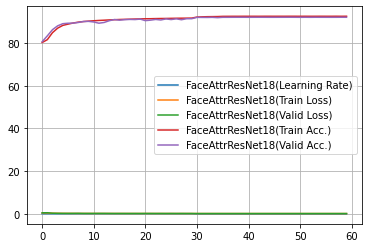

In [19]:
# config.epoch = 1
start_time = time.time()
model = create_model(device)
dataloaders, attribute_names  = load_dataloaders()
criterion = get_criterion()
# criterion = nn.CrossEntropyLoss().to(device)
# print(criterion)
optimizer = torch.optim.SGD(model.parameters(), config.lr,
                            momentum=config.momentum,
                            weight_decay=config.weight_decay)
# print(optimizer)
if config.evaluate:
    best_prec1, _, _ = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.checkpoint_fname) # checkpoint_fname bestmodel_fname
    test_loss, prec1, top1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
    print_attribute_acc(top1, attribute_names)
else:
    best_prec1, start_epoch, logger = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.ckp_resume)
    run_name, run_time = get_run_name_time(model, criterion, optimizer, comments)
    trainer(dataloaders, model, criterion, optimizer, logger, start_epoch, best_prec1, run_name)
end_time = time.time()
time_taken = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))
print(f"total time taken: {time_taken}")

In [20]:
# reset_gpu_cache(model,optimizer,criterion, device)

In [21]:
if not config.evaluate:
    config.evaluate = True
    model = create_model(device)
    dataloaders, attribute_names = load_dataloaders()
    criterion = get_criterion()
    #criterion = nn.CrossEntropyLoss().to(device)
    best_prec1, _, _ = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.bestmodel_fname)# config.bestmodel_fname  config.checkpoint_fname
    print(model)
    test_loss, prec1, top1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
    print_attribute_acc(top1, attribute_names)

=> creating model 'FaceAttrResNet'
Dataset sizes: {'test': 19962}
Class Labels: 40
=> resuming model: checkpoints\model_best.pth.tar
=> loading checkpoint 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/156 [00:00<?, ?it/s]

=> loaded checkpoint 'checkpoints\model_best.pth.tar' (epoch 49)
FaceAttrResNet(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.57it/s]

=> Best test accuracy: 91.60605148234785, Model val acc: 92.08863945016924
5_o_Clock_Shadow: 94.68490129338394
Arched_Eyebrows: 84.38032257474504
Attractive: 83.132952602315
Bags_Under_Eyes: 85.55254984699812
Bald: 99.0381725308604
Bangs: 96.31299466162834
Big_Lips: 71.90662257144164
Big_Nose: 84.48552245757418
Black_Hair: 90.47189659055208
Blond_Hair: 96.14267104370252
Blurry: 96.43322308953785
Brown_Hair: 89.65534514585892
Bushy_Eyebrows: 92.86644621958845
Chubby: 95.78699527194321
Double_Chin: 96.32802320976629
Eyeglasses: 99.66937180643222
Goatee: 97.60545033045085
Gray_Hair: 98.27672574458244
Heavy_Makeup: 91.86955211392123
High_Cheekbones: 87.80182346993345
Male: 98.45706843613216
Mouth_Slightly_Open: 94.2691112862669
Mustache: 97.01933674592077
Narrow_Eyes: 87.6314998550652
No_Beard: 96.29796610126012
Oval_Face: 76.46027452617737
Pale_Skin: 97.20969843312646
Pointy_Nose: 77.36699729638902
Receding_Hairline: 93.98356876768864
Rosy_Cheeks: 95.21591020115343
Sideburns: 97.911030961

In [22]:
# Wait for notebook to save
%autosave 1
time.sleep(150)
%autosave 120

Autosaving every 1 seconds


Autosaving every 120 seconds


In [23]:
def backup_everything(run_time, run_name, title):
    # backup checkpoints
    run_dir = os.path.join(config.BACKUP_DIR, run_name, run_time)
    create_dir_ifne(run_dir)
    fromDirectory = config.CHECKPOINT_DIR
    toDirectory = run_dir
    copy_tree(fromDirectory, toDirectory)
    # backup notebook html
    nb_name = title + '.ipynb'
    html_name = title + '.html'
    save_name = os.path.join(run_dir, html_name)
    !jupyter nbconvert --to html $nb_name
    !move $html_name $save_name
    
backup_everything(run_time, run_name, title)

[NbConvertApp] Converting notebook ai6126-project1-colab-v0.8.ipynb to html
[NbConvertApp] Writing 1046372 bytes to ai6126-project1-colab-v0.8.html
The syntax of the command is incorrect.


In [24]:
if config.auto_hibernate and False:
    os.system('shutdown -h')